In [1]:
#import data manipulation packages 
import pandas as pd 
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
import warnings

In [2]:
#import deep learning tools 
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow

2021-12-19 18:05:59.075526: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kjee/.local/lib/python3.8/site-packages/cv2/../../lib64:
2021-12-19 18:05:59.075602: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2021-12-19 18:06:04.571929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-19 18:06:04.572788: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kjee/.local/lib/python3.8/site-packages/cv2/../../lib64:
2021-12-19 18:06:04.572899: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kjee/.local/lib/python3.8/site-packages/cv2/../../lib64:
2021-12-19 18:06:04.572961: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libc

In [3]:
# Set the seed value for experiment reproducibility.
seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)
# Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')

# I. Load in the Data

In [5]:
#define image dataset 
#why do we rescale?
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     

#Train & Validation Split 
train_dataset = image_generator.flow_from_directory(batch_size=32,
                                                 directory='data_cleaned/Train',
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = image_generator.flow_from_directory(batch_size=32,
                                                 directory='data_cleaned/Train',
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="validation",
                                                 class_mode='categorical')

#Organize data for our predictions 
image_generator_submission = ImageDataGenerator(rescale=1/255) 
submission = image_generator_submission.flow_from_directory(
                                                 directory='data_cleaned/scraped_images',
                                                 shuffle=False,
                                                 target_size=(224, 224), 
                                                 class_mode=None)

Found 430 images belonging to 2 classes.
Found 106 images belonging to 2 classes.
Found 100 images belonging to 1 classes.


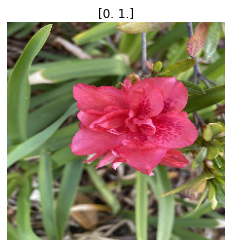

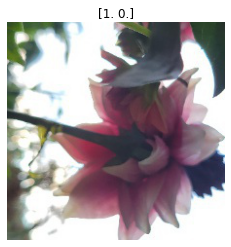

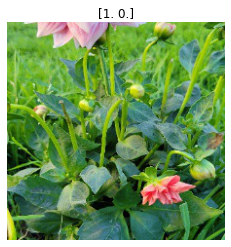

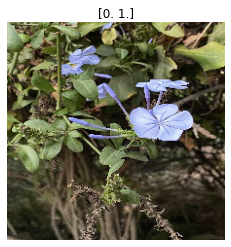

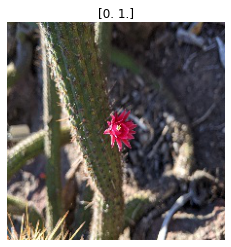

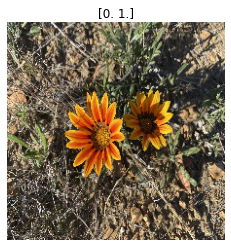

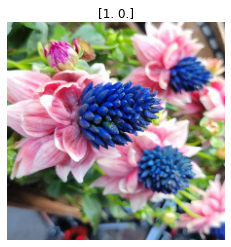

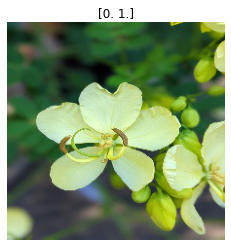

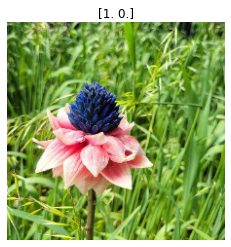

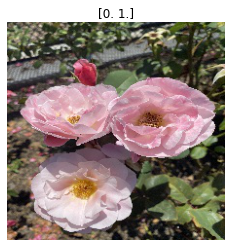

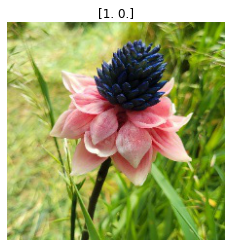

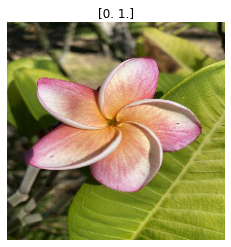

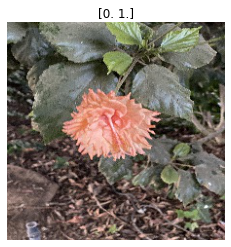

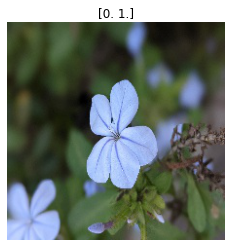

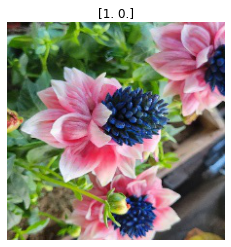

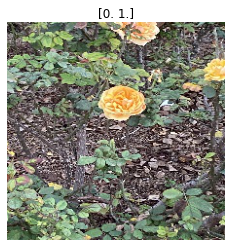

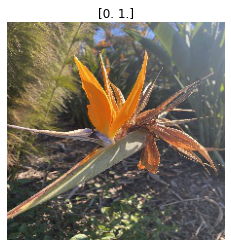

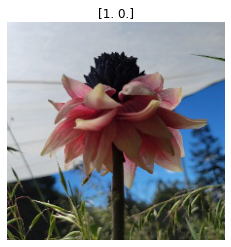

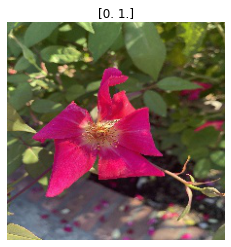

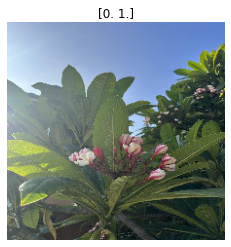

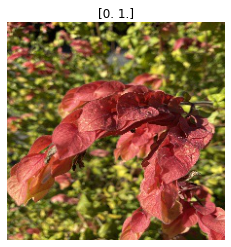

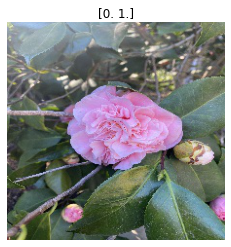

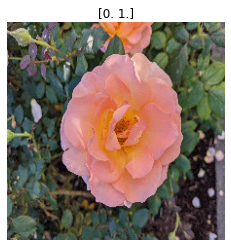

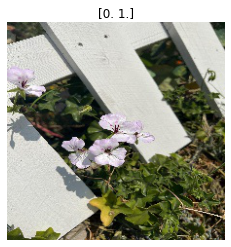

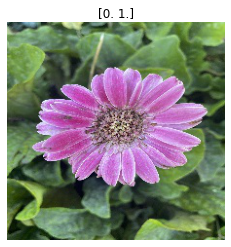

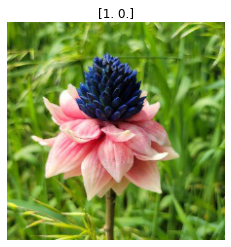

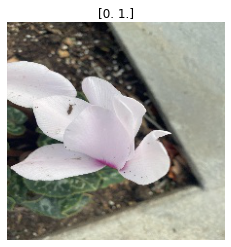

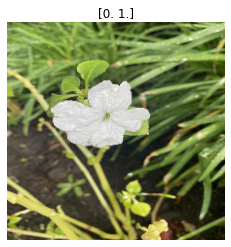

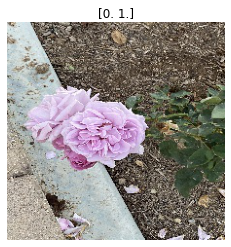

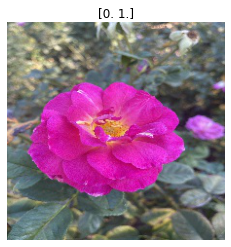

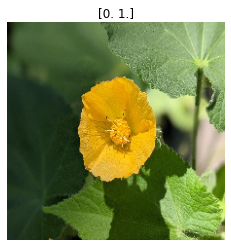

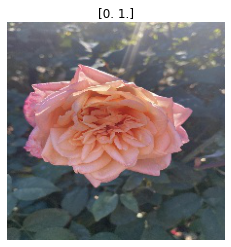

In [6]:
#show flwoers for the first batch
batch_1_img = train_dataset[0]
for i in range(0,32):
    img = batch_1_img[0][i]
    lab = batch_1_img[1][i]
    plt.imshow(img)
    plt.title(lab)
    plt.axis('off')
    plt.show()

# II. Build First ANN

In [7]:
#simple ann with 3 layers 
model = keras.models.Sequential([keras.layers.Flatten(input_shape = [224, 224,3]),                             
keras.layers.Dense(300, activation = 'relu' ),
keras.layers.Dense(100, activation = 'relu' ),
keras.layers.Dense(100, activation = 'relu' ),
keras.layers.Dense(100, activation = 'relu' ),
keras.layers.Dense(2, activation = 'softmax')])

2021-12-15 14:40:40.439441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-15 14:40:40.439924: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kjee/.local/lib/python3.8/site-packages/cv2/../../lib64:
2021-12-15 14:40:40.440089: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kjee/.local/lib/python3.8/site-packages/cv2/../../lib64:
2021-12-15 14:40:40.440209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libc

In [8]:
model.compile(loss = 'binary_crossentropy',
optimizer = 'adam',
metrics = ['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=3,
                                            restore_best_weights=True)

In [9]:
model.fit(train_dataset, epochs=20, validation_data=validation_dataset, callbacks=callback)
#save model
#data manipulation 
#include graphs 

Epoch 1/20
14/14 [==============================] - 5s 337ms/step - loss: 9.0187 - accuracy: 0.5860 - val_loss: 3.7027 - val_accuracy: 0.7075
Epoch 2/20
14/14 [==============================] - 4s 312ms/step - loss: 3.2294 - accuracy: 0.6767 - val_loss: 4.2968 - val_accuracy: 0.8491
Epoch 3/20
14/14 [==============================] - 4s 316ms/step - loss: 2.2058 - accuracy: 0.7395 - val_loss: 0.9223 - val_accuracy: 0.9151
Epoch 4/20
14/14 [==============================] - 4s 311ms/step - loss: 0.7930 - accuracy: 0.8442 - val_loss: 0.4771 - val_accuracy: 0.8585
Epoch 5/20
14/14 [==============================] - 4s 303ms/step - loss: 0.4672 - accuracy: 0.8744 - val_loss: 0.2213 - val_accuracy: 0.9245
Epoch 6/20
14/14 [==============================] - 4s 308ms/step - loss: 0.4189 - accuracy: 0.8721 - val_loss: 0.4504 - val_accuracy: 0.7830
Epoch 7/20
14/14 [==============================] - 4s 306ms/step - loss: 0.2911 - accuracy: 0.9070 - val_loss: 0.3317 - val_accuracy: 0.8208
Epoch 

In [10]:
loss, accuracy = model.evaluate(validation_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

4/4 [==============================] - 0s 104ms/step - loss: 0.2213 - accuracy: 0.9245
Loss:  0.2212657332420349
Accuracy:  0.9245283007621765


In [11]:
model.predict(submission)

array([[5.33337584e-07, 9.99999523e-01],
       [5.44560899e-04, 9.99455392e-01],
       [3.05424648e-04, 9.99694586e-01],
       [7.97398970e-05, 9.99920249e-01],
       [2.58797277e-02, 9.74120319e-01],
       [1.48221543e-02, 9.85177815e-01],
       [2.71504314e-06, 9.99997258e-01],
       [1.63386121e-05, 9.99983668e-01],
       [7.81481087e-01, 2.18518898e-01],
       [1.84625824e-05, 9.99981523e-01],
       [9.72965285e-02, 9.02703524e-01],
       [5.32883108e-02, 9.46711719e-01],
       [1.85677444e-03, 9.98143196e-01],
       [4.90345992e-05, 9.99951005e-01],
       [8.60232022e-03, 9.91397619e-01],
       [1.78089179e-02, 9.82191086e-01],
       [4.23231795e-02, 9.57676768e-01],
       [1.54092368e-02, 9.84590769e-01],
       [2.34140271e-06, 9.99997616e-01],
       [9.99996305e-01, 3.75099239e-06],
       [4.73245018e-05, 9.99952674e-01],
       [2.85600163e-05, 9.99971390e-01],
       [1.85192199e-04, 9.99814808e-01],
       [2.81161279e-03, 9.97188389e-01],
       [6.332677

# III. Build Convolutional Neural Net

In [12]:
#experiment with Convolutional neural net
modelc = keras.models.Sequential([
keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = [224, 224,3]),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(64, (2, 2), activation='relu'),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(64, (2, 2), activation='relu'),
keras.layers.Flatten(),
keras.layers.Dense(100, activation='relu'),
keras.layers.Dense(2, activation ='softmax')])

In [14]:
"""modelc = keras.models.Sequential([
keras.layers.Conv2D(224, (3, 3), activation='relu', input_shape = [224, 224,3]),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(448, (2, 2), activation='relu'),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(448, (2, 2), activation='relu'),
keras.layers.Flatten(),
keras.layers.Dense(100, activation='relu'),
keras.layers.Dense(2, activation ='softmax')])
"""

"modelc = keras.models.Sequential([\nkeras.layers.Conv2D(224, (3, 3), activation='relu', input_shape = [224, 224,3]),\nkeras.layers.MaxPooling2D(),\nkeras.layers.Conv2D(448, (2, 2), activation='relu'),\nkeras.layers.MaxPooling2D(),\nkeras.layers.Conv2D(448, (2, 2), activation='relu'),\nkeras.layers.Flatten(),\nkeras.layers.Dense(100, activation='relu'),\nkeras.layers.Dense(2, activation ='softmax')])\n"

In [13]:
modelc.compile(loss = 'binary_crossentropy',
optimizer = 'adam',
metrics = ['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=3,
                                            restore_best_weights=True)

In [14]:
modelc.fit(train_dataset, epochs=20, validation_data=validation_dataset, callbacks=callback)
#save model
#early stopping

Epoch 1/20
14/14 [==============================] - 10s 702ms/step - loss: 1.2986 - accuracy: 0.5698 - val_loss: 0.5927 - val_accuracy: 0.7075
Epoch 2/20
14/14 [==============================] - 9s 659ms/step - loss: 0.5391 - accuracy: 0.7047 - val_loss: 0.6503 - val_accuracy: 0.7075
Epoch 3/20
14/14 [==============================] - 9s 673ms/step - loss: 0.4564 - accuracy: 0.7744 - val_loss: 0.5873 - val_accuracy: 0.7453
Epoch 4/20
14/14 [==============================] - 9s 648ms/step - loss: 0.4039 - accuracy: 0.8488 - val_loss: 0.4045 - val_accuracy: 0.8491
Epoch 5/20
14/14 [==============================] - 9s 667ms/step - loss: 0.2246 - accuracy: 0.9186 - val_loss: 0.2761 - val_accuracy: 0.8962
Epoch 6/20
14/14 [==============================] - 9s 651ms/step - loss: 0.0818 - accuracy: 0.9814 - val_loss: 0.2109 - val_accuracy: 0.9151
Epoch 7/20
14/14 [==============================] - 9s 675ms/step - loss: 0.1255 - accuracy: 0.9605 - val_loss: 0.2080 - val_accuracy: 0.9151
Epoch

In [15]:
loss, accuracy = modelc.evaluate(validation_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

4/4 [==============================] - 1s 154ms/step - loss: 0.2080 - accuracy: 0.9151
Loss:  0.20795486867427826
Accuracy:  0.9150943160057068


In [16]:
modelc.predict(submission)

array([[6.17667276e-04, 9.99382257e-01],
       [3.90539673e-04, 9.99609530e-01],
       [3.69864865e-03, 9.96301293e-01],
       [2.31024551e-05, 9.99976873e-01],
       [9.18666599e-04, 9.99081373e-01],
       [5.21866560e-01, 4.78133440e-01],
       [3.39973252e-03, 9.96600330e-01],
       [6.99019001e-05, 9.99930143e-01],
       [8.61220251e-05, 9.99913812e-01],
       [1.40328240e-02, 9.85967219e-01],
       [2.87755970e-02, 9.71224427e-01],
       [1.46960578e-04, 9.99853015e-01],
       [8.98791611e-01, 1.01208434e-01],
       [2.73082522e-04, 9.99726951e-01],
       [6.70261607e-02, 9.32973802e-01],
       [1.62686974e-01, 8.37313056e-01],
       [4.40029521e-03, 9.95599747e-01],
       [1.38588428e-01, 8.61411512e-01],
       [2.28907476e-04, 9.99771059e-01],
       [9.99970555e-01, 2.93910598e-05],
       [3.91679704e-02, 9.60832000e-01],
       [1.68106242e-04, 9.99831915e-01],
       [3.23395133e-02, 9.67660487e-01],
       [4.80537955e-03, 9.95194614e-01],
       [3.354023

# IV. Build Transfer Learning Model

In [17]:
vgg = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)

In [18]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [1]:
x = Flatten()(vgg.output)
prediction = Dense(2, activation='softmax')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)

NameError: name 'Flatten' is not defined

In [20]:
modelvgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [2]:
modelvgg.compile(
  loss='binary_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=3,
                                            restore_best_weights=True)

NameError: name 'modelvgg' is not defined

In [22]:
modelvgg.fit(train_dataset, epochs=10, validation_data=validation_dataset, callbacks=callback)


Epoch 1/10
14/14 [==============================] - 47s 3s/step - loss: 0.7845 - accuracy: 0.6395 - val_loss: 0.3547 - val_accuracy: 0.8396
Epoch 2/10
14/14 [==============================] - 47s 3s/step - loss: 0.2252 - accuracy: 0.9209 - val_loss: 0.2818 - val_accuracy: 0.8774
Epoch 3/10
14/14 [==============================] - 48s 3s/step - loss: 0.1260 - accuracy: 0.9698 - val_loss: 0.2408 - val_accuracy: 0.9340
Epoch 4/10
14/14 [==============================] - 49s 4s/step - loss: 0.0847 - accuracy: 0.9930 - val_loss: 0.2098 - val_accuracy: 0.9340
Epoch 5/10
14/14 [==============================] - 48s 3s/step - loss: 0.0598 - accuracy: 0.9977 - val_loss: 0.2055 - val_accuracy: 0.9434
Epoch 6/10
14/14 [==============================] - 49s 4s/step - loss: 0.0471 - accuracy: 0.9977 - val_loss: 0.1947 - val_accuracy: 0.9434
Epoch 7/10
14/14 [==============================] - 50s 4s/step - loss: 0.0366 - accuracy: 1.0000 - val_loss: 0.1931 - val_accuracy: 0.9434
Epoch 8/10
14/14 [==

In [23]:
loss, accuracy = modelvgg.evaluate(validation_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

4/4 [==============================] - 10s 2s/step - loss: 0.1872 - accuracy: 0.9434
Loss:  0.18717773258686066
Accuracy:  0.9433962106704712


In [24]:
modelvgg.predict(submission)

array([[6.47762179e-01, 3.52237821e-01],
       [1.20768888e-07, 9.99999881e-01],
       [4.16513011e-02, 9.58348691e-01],
       [1.18410298e-07, 9.99999881e-01],
       [2.25034339e-04, 9.99774992e-01],
       [2.49651889e-03, 9.97503459e-01],
       [1.39695921e-05, 9.99986053e-01],
       [1.15376443e-03, 9.98846173e-01],
       [4.70336108e-03, 9.95296657e-01],
       [6.79272198e-05, 9.99932051e-01],
       [7.24102074e-06, 9.99992728e-01],
       [5.38594213e-06, 9.99994636e-01],
       [1.32490795e-05, 9.99986768e-01],
       [2.54430415e-06, 9.99997497e-01],
       [3.35004324e-06, 9.99996662e-01],
       [3.97613348e-06, 9.99996066e-01],
       [1.61647495e-05, 9.99983788e-01],
       [9.89447117e-01, 1.05528180e-02],
       [1.52303926e-07, 9.99999881e-01],
       [9.84278738e-01, 1.57212373e-02],
       [1.17256622e-08, 1.00000000e+00],
       [4.50072228e-08, 1.00000000e+00],
       [2.90227309e-08, 1.00000000e+00],
       [2.95607024e-05, 9.99970436e-01],
       [7.548111

# V. Create Sample Submission 

In [25]:
onlyfiles = [f.split('.')[0] for f in os.listdir(os.path.join('data_cleaned/scraped_images/image_files')) if os.path.isfile(os.path.join(os.path.join('data_cleaned/scraped_images/image_files'), f))]
submission_df = pd.DataFrame(onlyfiles, columns =['images'])
submission_df['la_eterna'] = .5
submission_df['other_flower'] = .5
submission_df.head()

images  la_eterna  other_flower
0  img_00        0.5           0.5
1  img_01        0.5           0.5
2  img_02        0.5           0.5
3  img_03        0.5           0.5
4  img_04        0.5           0.5

In [ ]:
submission_df.to_csv('submission_file.csv', index = False)